In [2]:
import os
import re
import cv2
import math
import random
import imutils
import numpy as np
import pandas as pd
from typing import Any
from openpyxl import Workbook
from paddleocr import PaddleOCR
from matplotlib import pyplot as plt
# from trdg.generators import GeneratorFromStrings
from tensorflow.keras.preprocessing import image as tfimage

2023-07-06 10:25:13.749416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vivaansinghvi07/smoky-mountain-comp/.venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-07-06 10:25:13.749444: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# type decls
cv2.Image = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: cv2.Image) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# for quietly stopping jupyter cell
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

Defines image cropper to center the text in the image

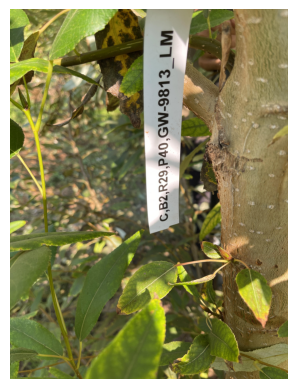

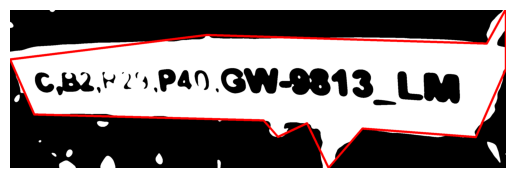

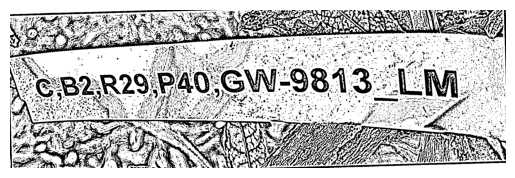

In [7]:
def process_image(img: cv2.Image, strength: int = 1) -> cv2.Image:
    gray = grayscale(img)
    blur = tfimage.img_to_array(cv2.medianBlur(gray, 5), dtype='uint8')
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, strength)
    return thresh

def get_largest_contour(img: cv2.Image) -> cv2.Contour:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 150, 255, 0)[1]
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    return thresh, sorted(contours, key=cv2.contourArea, reverse=True)[0]

# not used for now D:
def crop_image(img: cv2.Image, debug: bool = False) -> cv2.Image:

    if debug: imshow(img)

    thresh, big_contour = get_largest_contour(img)
    x, y, w, h = cv2.boundingRect(big_contour)
    newimg = img[y:y+h, x:x+w]

    # perform 90-deg rotation if the cropped image is wider than tall
    if h > w: newimg = np.array([[newimg[j][i] for j in reversed(range(len(newimg)))] for i in range(len(newimg[0]))])

    # get the longest line in the approximation
    newimg_thresh, newimg_big_contour = get_largest_contour(newimg)
    approx = cv2.approxPolyDP(newimg_big_contour, 0.010*cv2.arcLength(newimg_big_contour, True), True)
    simplified_approx = list(map(lambda x: tuple(x[0]), approx))
    max_lines = sorted(
        zip(simplified_approx, simplified_approx[1:] + [simplified_approx[0]]),  # connects all the points with the adjacent one
        key=lambda l: (l[0][0]-l[1][0])**2 + (l[0][1]-l[1][1])**2                # distance formula
    )[-2:]

    def get_angle(line: tuple[tuple[int]]) -> float:

        # flatten the longest line, from / to __
        y_dist = line[0][1]-line[1][1]
        x_dist = line[0][0]-line[1][0]
        angle = math.degrees(math.atan(y_dist/x_dist))
        return angle

    if debug:
        drawn_contours = cv2.drawContours(cv2.cvtColor(newimg_thresh.copy(), cv2.COLOR_GRAY2BGR), [approx], -1, (0, 0, 255), 10)
        imshow(drawn_contours)
        
    newimg = imutils.rotate(newimg, angle=float(np.average([*map(get_angle, max_lines)])))

    return newimg

test_index = 0
img = crop_image(cv2.imread("sample_dataset/001FD477-9448-4514-BA0A-599AA304357C.jpg"), debug=True)
img = process_image(img)
imshow(img)

Generate synthetic data to train neural network

**NOT USED RIGHT NOW**

In [12]:
# comment out to use this cell
raise StopExecution

ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
IMG_COUNT = 100
DATA_PATH = 'synthetic-data'
IMAGES_PATH = f'{DATA_PATH}/images'

os.system(f"{'rm -rf' if os.name != 'nt' else 'rmdir /s /q'} {DATA_PATH}")
os.system(f"mkdir {DATA_PATH} {IMAGES_PATH}")
os.system(f"echo '*' > {DATA_PATH}/.gitignore")

def get_random_text():
    treatment = random.choice(['C', 'D'])
    block = f"B{random.choice(['1', '2'])}"
    row = f"R{random.randint(1, 99)}"
    position = f"P{random.randint(1, 99)}"
    
    gen_length = random.randint(2, 4)
    num_count = random.choices([1, 2, 3], weights=(70, 15, 15))[0]
    num_lengths = random.choices([1, 2, 3, 4], weights=(15, 15, 15, 55), k=num_count)

    genotype = (
        "".join([ALPHABET[random.randint(0, 25)] for _ in range(gen_length)]) + 
        f"-{'-'.join([str(random.randint(10**(i-1), 10**i-1)) for i in num_lengths])}_LM"
    )

    return ','.join([treatment, block, row, position, genotype])

# generate the new images, limiting count
generator = GeneratorFromStrings(
    [get_random_text() for _ in range(1000)],
    random_blur=True,
    random_skew=True,
    fonts=['assets/image_font.ttf']
)
i = 0
for img, lbl in generator:
    if i == IMG_COUNT: break
    img.save(f'{IMAGES_PATH}/{lbl}_{i}.png')
    i += 1

# randomly selects one image for exemplary purposes
example_img = random.choice(os.listdir(IMAGES_PATH))
imshow(cv2.imread(f"{IMAGES_PATH}/{example_img}"))

Read and obtain text from the images

In [15]:
PADDLE_OCR = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, rotation=True)
SHOW_IMAGE = "False"
ROTATION_ANGLE = -45
MIN_LEN = 8
DATASET_PATH = "./dataset"

def get_text(text: Any, mode: str) -> str:
    if mode == "paddle":
        output = ""
        if text == [[]]:
            return None
        s = sorted(text[0], key=lambda x: x[0][0])
        if re.search(r"[BR]\d", s[-1][1][0]) is not None:
            s = reversed(s)
        for item in s:
            output += item[1][0]
        if len(output) < MIN_LEN:
            return None
        return output
    
# preload cropped images and empty text array
ocr_texts = []

# try many different image configurations to get some text
for filename in os.listdir(DATASET_PATH):
    image = cv2.imread(f"{DATASET_PATH}/{filename}")
    img_was_rotated = False
    if (text:=get_text(PADDLE_OCR.ocr(image), mode="paddle")) is None:
        bw_image = process_image(image, strength=-2)
        if (text:=get_text(PADDLE_OCR.ocr(bw_image), mode="paddle")) is None:
            rt_image = imutils.rotate(image, ROTATION_ANGLE)
            img_was_rotated = True
            if (text:=get_text(PADDLE_OCR.ocr(rt_image), mode="paddle")) is None:
                bw_rt_image = process_image(rt_image, strength=-2)
                text = get_text(PADDLE_OCR.ocr(bw_rt_image), mode="paddle")
    
    # add to texts and show image
    ocr_texts.append((filename, text))
    if eval(SHOW_IMAGE):
        imshow(image)

# calculate reading percentage
print(f"Texts not detected: \033[31m{sum(map(lambda x: x[1] is None, ocr_texts))/len(ocr_texts):.2%}\033[0m")

Texts not detected: 9.27%


In [9]:
df_list = []
for (filename, text) in ocr_texts:

    df_row = {
        'filename': filename,
        'treatment': None,
        'block': None,
        'row': None,
        'position': None,
        'genotype': None
    }
    df_list.append(df_row)

    if text is None:
        continue

    text = text.replace(' ', '_').upper()

    # get block, row, position
    if (block:=re.search(r"B\d+", text)) is not None:
        df_row['block'] = int(block.group().replace('B', ''))
    if (position:=re.search(r"P\d+", text)) is not None:
        df_row['position'] = int(position.group().replace('P', ''))
    if (row:=re.search(r"R\d+", text)) is not None:
        df_row['row'] = int(row.group().replace('R', ''))

    # get treatment
    if (u:=text[0].upper()) in ['C', 'D']:
        df_row['treatment'] = text[0]

    # get genotype
    if (genotype:=re.search(r"[A-Z]{2,}(-\d+)+(_\d+)*(_[A-Z]+)?", text)) is not None:
        genotype = genotype.group()
        if '*' in text:
            genotype = f"**{genotype}**,core"
        df_row['genotype'] = genotype

df = pd.DataFrame(df_list)
for col in ['position', 'block', 'row']:
    df[col] = pd.to_numeric(df[col])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672 entries, 0 to 1671
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   filename   1672 non-null   object 
 1   treatment  1098 non-null   object 
 2   block      1306 non-null   float64
 3   row        1388 non-null   float64
 4   position   1414 non-null   float64
 5   genotype   1431 non-null   object 
dtypes: float64(3), object(3)
memory usage: 78.5+ KB


In [11]:
df.tail()

,filename,treatment,block,row,position,genotype
1667,91F395A8-E156-416C-84E8-A2880F067945.jpg,None,NaN,NaN,NaN,None
1668,18E8E0DC-35EE-4C34-839A-71E0E6D7F3AD.jpg,C,1.0,12.0,27.0,GW-6962_WP
1669,DB2D48CC-17CD-4A96-BC52-CFFC5879641B.jpg,C,2.0,5.0,49.0,GW-9784_LM
1670,2258AE77-D53C-446F-8DAD-0E948854EBDC.jpg,C,2.0,42.0,43.0,"**GW-4579_WP**,core"
1671,5FCC7048-CC04-40DA-B3DB-F6404CA41931.jpg,C,2.0,38.0,31.0,BESC-217_LM


In [12]:
EXAMPLE_DATA = pd.DataFrame({
    'filename': ['example1.png', 'example2.png'],
    'treatment': ['C', 'D'],
    'block': ['1', '2'],
    'row': ['54', '23'],
    'position': ['12', '10'],
    'genotype': ['BESC-4590_LM', 'BESC-4230_LM']
})

def make_sheet(data: pd.DataFrame, excel_file: str) -> None:
    wb = Workbook()
    worksheet = wb.active
    
    # For writing the Header Rows on Excel
    headers = [*data.keys()]
    worksheet.append(headers)

    # For writing the data rows for each image in the dataset
    for i in range(len(data)):
        row = [data[header][i] for header in headers]
        worksheet.append(row)

    wb.save(excel_file)
        
make_sheet(df, 'data.xlsx')